In [ ]:
pip install torch torchvision matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Define the data augmentation transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=weak_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 170M/170M [00:05<00:00, 29.6MB/s]


In [ ]:
# Let's split the dataset into labeled and unlabeled data
labeled_data = torch.utils.data.Subset(train_dataset, range(250))  # 250 labeled samples
unlabeled_data = torch.utils.data.Subset(train_dataset, range(250, len(train_dataset)))  # Rest are unlabeled


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions by 2x

        # Adjust based on shape after conv layers
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))  # Apply pooling

        print("Shape before flattening:", x.shape)  # Debugging

        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
# Instantiate model
model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training function
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10, threshold=0.95):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for (labeled_data, unlabeled_data) in zip(labeled_loader, unlabeled_loader):
            # Get the labeled data and labels
            inputs_l, labels_l = labeled_data
            inputs_u, _ = unlabeled_data  # No labels for unlabeled data

            # Forward pass for labeled data
            outputs_l = model(inputs_l)
            loss_l = criterion(outputs_l, labels_l)

            # Generate pseudo-labels for unlabeled data
            with torch.no_grad():
                outputs_u = model(inputs_u)
                pseudo_labels = torch.argmax(outputs_u, dim=1)
                max_probs = torch.max(torch.softmax(outputs_u, dim=1), dim=1)[0]
                mask = max_probs >= threshold  # Only take pseudo-labels where the model is confident

            # Forward pass for unlabeled data with pseudo-labels
            if mask.sum() > 0:
                outputs_u_masked = model(inputs_u[mask])
                loss_u = criterion(outputs_u_masked, pseudo_labels[mask])
            else:
                loss_u = 0

            # Total loss: Sum of labeled and unlabeled losses
            total_loss = loss_l + loss_u
            running_loss += total_loss.item()

            # Backpropagation and optimizer step
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(labeled_loader)}")


In [ ]:
batch_size = 8
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
# # Instantiate model
# model = SimpleCNN()

# Train the model with FixMatch
train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)


In [ ]:
model = SimpleCNN()  # Instantiate the model
train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

# Evaluate on test data
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
evaluate(model, test_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

# ----------------------------
# 1. Data Preprocessing
# ----------------------------
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_weak)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting labeled and unlabeled datasets
labeled_size = 4000  # 4k labeled, rest unlabeled
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)

labeled_indices = indices[:labeled_size]
unlabeled_indices = indices[labeled_size:]

labeled_data = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_data = torch.utils.data.Subset(train_dataset, unlabeled_indices)

batch_size = 64
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# 2. Model Definition
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Downsampling by factor of 2

        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, 10)  # 10 classes (CIFAR-10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # print("Shape before flattening:", x.shape)  # Debugging output
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# 3. FixMatch Training
# ----------------------------
from torchvision import transforms

def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10, threshold=0.95):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    to_pil = transforms.ToPILImage()  # Convert tensor to PIL image before transformation

    for epoch in range(epochs):
        for (labeled_data, unlabeled_data) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = labeled_data
            inputs_u, _ = unlabeled_data  # Unlabeled images

            # Move to device
            inputs_x, targets_x = inputs_x.to('cpu'), targets_x.to('cpu')
            inputs_u = inputs_u.to('cpu')

            # Forward pass for labeled data
            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            # Convert each tensor in inputs_u to PIL image, apply transformations, then back to tensor
            inputs_u_weak = torch.stack([transform_weak(to_pil(img)) for img in inputs_u])
            inputs_u_strong = torch.stack([transform_strong(to_pil(img)) for img in inputs_u])

            inputs_u_weak = inputs_u_weak.to('cpu')
            inputs_u_strong = inputs_u_strong.to('cpu')

            # Compute pseudo-labels from weakly augmented data
            outputs_u_weak = model(inputs_u_weak)
            pseudo_labels = torch.softmax(outputs_u_weak, dim=-1).max(dim=-1)[1]  # Get pseudo-labels

            # Confidence threshold mask
            mask = (torch.softmax(outputs_u_weak, dim=-1).max(dim=-1)[0] > threshold).float()
            outputs_u_strong = model(inputs_u_strong)

            # Compute loss for unlabeled data
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            # Total loss
            loss = loss_x + loss_u

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# ----------------------------
# 4. Evaluation
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# ----------------------------
# 5. Run Training and Evaluation
# ----------------------------
model = SimpleCNN()
train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)


Epoch [1/10], Loss: 1.7654
Epoch [2/10], Loss: 1.8885
Epoch [3/10], Loss: 1.6871
Epoch [4/10], Loss: 1.7784
Epoch [5/10], Loss: 1.6302
Epoch [6/10], Loss: 1.5871
Epoch [7/10], Loss: 1.8617
Epoch [8/10], Loss: 1.3527
Epoch [9/10], Loss: 1.4614
Epoch [10/10], Loss: 1.1250
Test Accuracy: 55.10%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load ResNet18 pre-trained model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Epoch 1: Loss = 0.9775
Epoch 2: Loss = 0.6285
Epoch 3: Loss = 0.8608
Epoch 4: Loss = 0.7472
Epoch 5: Loss = 0.6278
Epoch 6: Loss = 0.6051
Epoch 7: Loss = 0.8105
Epoch 8: Loss = 0.5076
Epoch 9: Loss = 0.3119
Epoch 10: Loss = 0.2010
Test Accuracy: 83.34%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models

# ----------------------------
# 1. Data Preprocessing
# ----------------------------
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_weak)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# ----------------------------
# 2. Data Splitting (Stratified Sampling)
# ----------------------------

labeled_size = 4000  # Number of labeled samples
# Get labels of the training set
labels = np.array(train_dataset.targets)

# Stratified split to ensure all classes are represented
labeled_indices, unlabeled_indices = train_test_split(np.arange(len(train_dataset)),
                                                     train_size=labeled_size,
                                                     stratify=labels)

# Create labeled and unlabeled datasets
labeled_data = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_data = torch.utils.data.Subset(train_dataset, unlabeled_indices)

batch_size = 64
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# 3. Model Definition: Using Pretrained ResNet-18
# ----------------------------
class ResNet18ForCIFAR10(nn.Module):
    def __init__(self):
        super(ResNet18ForCIFAR10, self).__init__()
        # Load pre-trained ResNet-18 model
        self.model = models.resnet18(pretrained=True)
        # Modify the first convolution layer to accept 3-channel input (CIFAR-10 images)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the final fully connected layer to output 10 classes (CIFAR-10 classes)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

# ----------------------------
# 4. FixMatch Training
# ----------------------------
from torchvision import transforms

def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10, threshold=0.95):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    to_pil = transforms.ToPILImage()  # Convert tensor to PIL image before transformation

    for epoch in range(epochs):
        for (labeled_data, unlabeled_data) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = labeled_data
            inputs_u, _ = unlabeled_data  # Unlabeled images

            # Move to device
            inputs_x, targets_x = inputs_x.to('cpu'), targets_x.to('cpu')
            inputs_u = inputs_u.to('cpu')

            # Forward pass for labeled data
            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            # Convert each tensor in inputs_u to PIL image, apply transformations, then back to tensor
            inputs_u_weak = torch.stack([transform_weak(to_pil(img)) for img in inputs_u])
            inputs_u_strong = torch.stack([transform_strong(to_pil(img)) for img in inputs_u])

            inputs_u_weak = inputs_u_weak.to('cpu')
            inputs_u_strong = inputs_u_strong.to('cpu')

            # Compute pseudo-labels from weakly augmented data
            outputs_u_weak = model(inputs_u_weak)
            pseudo_labels = torch.softmax(outputs_u_weak, dim=-1).max(dim=-1)[1]  # Get pseudo-labels

            # Confidence threshold mask
            mask = (torch.softmax(outputs_u_weak, dim=-1).max(dim=-1)[0] > threshold).float()
            outputs_u_strong = model(inputs_u_strong)

            # Compute loss for unlabeled data
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            # Total loss
            loss = loss_x + loss_u

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# ----------------------------
# 5. Evaluation
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# ----------------------------
# 6. Run Training and Evaluation
# ----------------------------
model = ResNet18ForCIFAR10()
train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)


100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.8MB/s]


Epoch [1/10], Loss: 1.9731
Epoch [2/10], Loss: 1.9716
Epoch [3/10], Loss: 1.9884
Epoch [4/10], Loss: 1.4636
Epoch [5/10], Loss: 2.0099
Epoch [6/10], Loss: 1.2930
Epoch [7/10], Loss: 1.5445
Epoch [8/10], Loss: 1.7356
Epoch [9/10], Loss: 1.5590
Epoch [10/10], Loss: 1.5477
Test Accuracy: 40.29%


In [ ]:
# ----------------------------
# 1. Imports & Preprocessing
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.transforms import ToPILImage
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Data Transforms
# ----------------------------
transform_weak = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_strong = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# ----------------------------
# 3. CIFAR-10 Dataset & Split
# ----------------------------
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_weak)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

labels = np.array(train_dataset.targets)
labeled_size = 4000
labeled_indices, unlabeled_indices = train_test_split(np.arange(len(train_dataset)),
                                                       train_size=labeled_size,
                                                       stratify=labels,
                                                       random_state=42)

labeled_data = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_data = torch.utils.data.Subset(train_dataset, unlabeled_indices)

batch_size = 8
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. ResNet50 for CIFAR-10

class ResNet50ForCIFAR10(nn.Module):
    def __init__(self):
        super(ResNet50ForCIFAR10, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
    def forward(self, x):
        return self.model(x)


# ----------------------------
# 5. FixMatch Training Function
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10, threshold=0.95):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    to_pil = ToPILImage()
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for (labeled_batch, unlabeled_batch) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = labeled_batch
            inputs_u, _ = unlabeled_batch
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u = inputs_u.to(device)

            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            inputs_u_weak = torch.stack([transform_weak(to_pil(img.cpu())) for img in inputs_u])
            inputs_u_strong = torch.stack([transform_strong(to_pil(img.cpu())) for img in inputs_u])
            inputs_u_weak = inputs_u_weak.to(device)
            inputs_u_strong = inputs_u_strong.to(device)

            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return epoch_losses

# ----------------------------
# 6. Evaluation Function
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1

# ----------------------------
# 7. Run Training & Plot
# ----------------------------
model = ResNet50ForCIFAR10()
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)

plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


100%|██████████| 170M/170M [00:03<00:00, 51.1MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 42.5MB/s]


In [ ]:
torch.save(model.state_dict(), "fixmatch_resnet50_cifar10.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.6533
Epoch [2/10], Loss: 1.1976
Epoch [3/10], Loss: 1.0739
Epoch [4/10], Loss: 1.0001
Epoch [5/10], Loss: 0.9132
Epoch [6/10], Loss: 0.8628
Epoch [7/10], Loss: 0.9413
Epoch [8/10], Loss: 0.7813
Epoch [9/10], Loss: 0.7451
Epoch [10/10], Loss: 0.6572
Test Accuracy: 57.29%
Precision: 0.7058, Recall: 0.5729, F1 Score: 0.5900


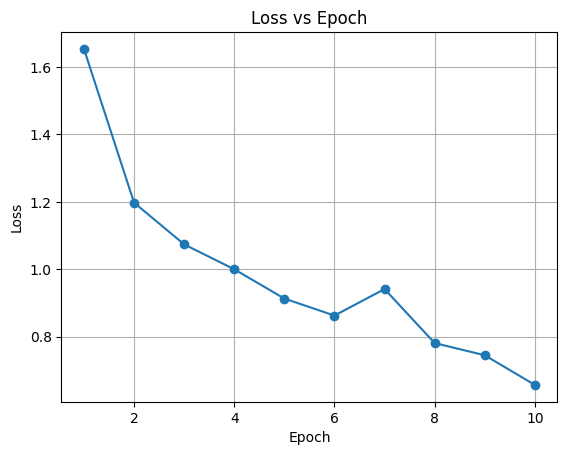

In [ ]:
# ----------------------------
# 1. Imports & Preprocessing
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.transforms import ToPILImage
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Data Transforms
# ----------------------------
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ----------------------------
# 3. CIFAR-10 Dataset & Split
# ----------------------------
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_weak)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

labels = np.array(train_dataset.targets)
labeled_size = 4000
labeled_indices, unlabeled_indices = train_test_split(np.arange(len(train_dataset)),
                                                       train_size=labeled_size,
                                                       stratify=labels,
                                                       random_state=42)

labeled_data = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_data = torch.utils.data.Subset(train_dataset, unlabeled_indices)

batch_size = 64
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# 4. DenseNet121 for CIFAR-10
# ----------------------------
class DenseNetForCIFAR10(nn.Module):
    def __init__(self):
        super(DenseNetForCIFAR10, self).__init__()
        self.model = models.densenet121(pretrained=True)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, 10)
    def forward(self, x):
        return self.model(x)

# ----------------------------
# 5. FixMatch Training Function
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10, threshold=0.95):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    to_pil = ToPILImage()
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for (labeled_batch, unlabeled_batch) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = labeled_batch
            inputs_u, _ = unlabeled_batch
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u = inputs_u.to(device)

            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            inputs_u_weak = torch.stack([transform_weak(to_pil(img.cpu())) for img in inputs_u])
            inputs_u_strong = torch.stack([transform_strong(to_pil(img.cpu())) for img in inputs_u])
            inputs_u_weak = inputs_u_weak.to(device)
            inputs_u_strong = inputs_u_strong.to(device)

            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return epoch_losses

# ----------------------------
# 6. Evaluation Function
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1

# ----------------------------
# 7. Run Training & Plot
# ----------------------------
model = DenseNetForCIFAR10()
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)

plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


In [ ]:
torch.save(model.state_dict(), "fixmatch_densenet_cifar10.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 109MB/s]


Epoch [1/10], Loss: 0.3703
Epoch [2/10], Loss: 0.1332
Epoch [3/10], Loss: 0.3758
Epoch [4/10], Loss: 0.1280
Epoch [5/10], Loss: 0.0910
Epoch [6/10], Loss: 0.0836
Epoch [7/10], Loss: 0.0915
Epoch [8/10], Loss: 0.0914
Epoch [9/10], Loss: 0.1590
Epoch [10/10], Loss: 0.1136


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 98.04%
Precision: 0.4902, Recall: 0.5000, F1 Score: 0.4950


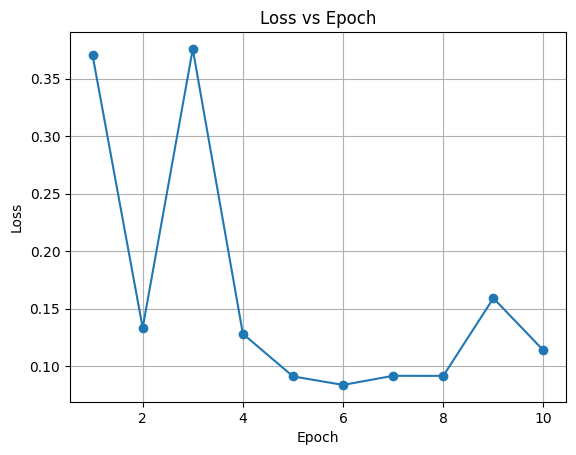

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.transforms import ToPILImage
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 1. Data Transforms (Enhanced Augmentations)
# ----------------------------
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
    transforms.RandomRotation(15),  # Added rotation for more variety
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

from torchvision.datasets import ImageFolder

data_dir = '/content/drive/MyDrive/ad'  # Your dataset path
full_dataset = ImageFolder(root=data_dir, transform=transform_weak)
test_dataset = ImageFolder(root=data_dir, transform=transform_test)

labels = np.array([sample[1] for sample in full_dataset])
labeled_size = 200  # Adjust based on how many labeled you want

labeled_idx, unlabeled_idx = train_test_split(
    np.arange(len(full_dataset)), train_size=labeled_size,
    stratify=labels, random_state=42)

labeled_data = torch.utils.data.Subset(full_dataset, labeled_idx)
unlabeled_data = torch.utils.data.Subset(full_dataset, unlabeled_idx)

batch_size = 64
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
#  4. WideResNet for CIFAR-10
# ----------------------------
class WideResNetForCIFAR10(nn.Module):
    def __init__(self):
        super(WideResNetForCIFAR10, self).__init__()
        # Load the pretrained WideResNet model with 50 layers and 2x width factor
        self.model = models.wide_resnet50_2(pretrained=True)
        # Modify the last layer to match  number of classes (10)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)


    def forward(self, x):
        return self.model(x)
# ----------------------------
# 4. FixMatch Training with Regularization & Optimizer Tweaks
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=100, threshold=0.95):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay for L2 regularization
    criterion = nn.CrossEntropyLoss()
    to_pil = ToPILImage()
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for (labeled_batch, unlabeled_batch) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = labeled_batch
            inputs_u, _ = unlabeled_batch
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u = inputs_u.to(device)

            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            inputs_u_weak = torch.stack([transform_weak(to_pil(img.cpu())) for img in inputs_u])
            inputs_u_strong = torch.stack([transform_strong(to_pil(img.cpu())) for img in inputs_u])
            inputs_u_weak = inputs_u_weak.to(device)
            inputs_u_strong = inputs_u_strong.to(device)

            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return epoch_losses

# ----------------------------
# 5. Evaluation Function
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1

# ----------------------------
# 6. Run Training & Plot
# ----------------------------
model = WideResNetForCIFAR10()
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


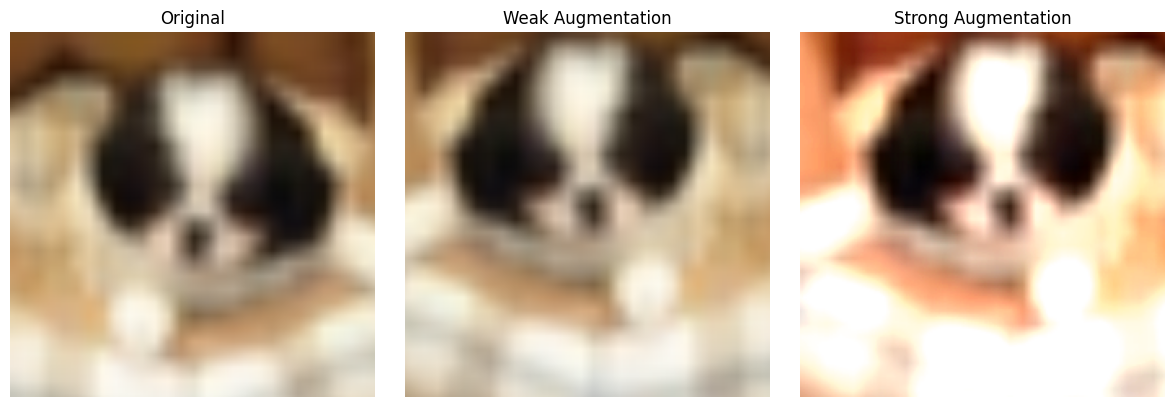

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ----------------------------
# 1. Imports & Setup
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random

torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Data Transforms
# ----------------------------
transform_weak = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

transform_strong = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ----------------------------
# 3. Custom FixMatch Dataset
# ----------------------------
class FixMatchDataset(Dataset):
    def __init__(self, base_dataset, transform_weak, transform_strong):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        return self.transform_weak(img), self.transform_strong(img)

    def __len__(self):
        return len(self.base_dataset)

# ----------------------------
# 4. CIFAR-10 Dataset
# ----------------------------
train_dataset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_weak)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

labels = np.array(train_dataset.targets)
labeled_size = 4000
labeled_indices, unlabeled_indices = train_test_split(
    np.arange(len(train_dataset)), train_size=labeled_size,
    stratify=labels, random_state=42
)

labeled_data = Subset(train_dataset, labeled_indices)
unlabeled_data = Subset(train_dataset_raw, unlabeled_indices)  # raw to apply two transforms manually

batch_size = 64
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
unlabeled_loader = DataLoader(FixMatchDataset(unlabeled_data, transform_weak, transform_strong),
                              batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ----------------------------
# 5. EfficientNet for CIFAR-10
# ----------------------------
class EfficientNetForCIFAR10(nn.Module):
    def __init__(self):
        super(EfficientNetForCIFAR10, self).__init__()
        self.model = efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 10)

    def forward(self, x):
        return self.model(x)

# ----------------------------
# 6. FixMatch Training
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=0, epochs=10, threshold=0.95):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    if os.path.exists("checkpoint.pth"):
        checkpoint = torch.load("checkpoint.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        model.train()

        for (inputs_x, targets_x), (inputs_u_weak, inputs_u_strong) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u_weak, inputs_u_strong = inputs_u_weak.to(device), inputs_u_strong.to(device)

            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)

        # Save checkpoint
        os.makedirs("checkpoints", exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, "checkpoint.pth")
        torch.save(model.state_dict(), f"checkpoints/epoch_{epoch+1}.pth")

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return epoch_losses

# ----------------------------
# 7. Evaluation
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1

# ----------------------------
# 8. Run Everything
# ----------------------------
model = EfficientNetForCIFAR10()
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)

# Plot loss
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


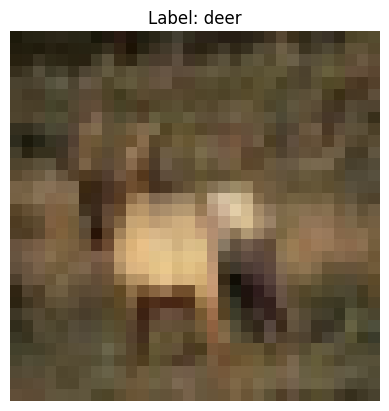

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-10 dataset without transformations
raw_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Select a random image from the dataset
image, label = raw_cifar10[3]  # Change index to see different images

# Convert the image to numpy array for displaying
image_np = np.array(image)

# Display the CIFAR-10 image at its original size (32x32, RGB)
plt.imshow(image_np)
plt.title(f"Label: {raw_cifar10.classes[label]}")
plt.axis('off')  # Hide axis for better visualization

# Ensure the image is shown at its original size
plt.show()


Loading preprocessed dataset from cache...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 219MB/s]


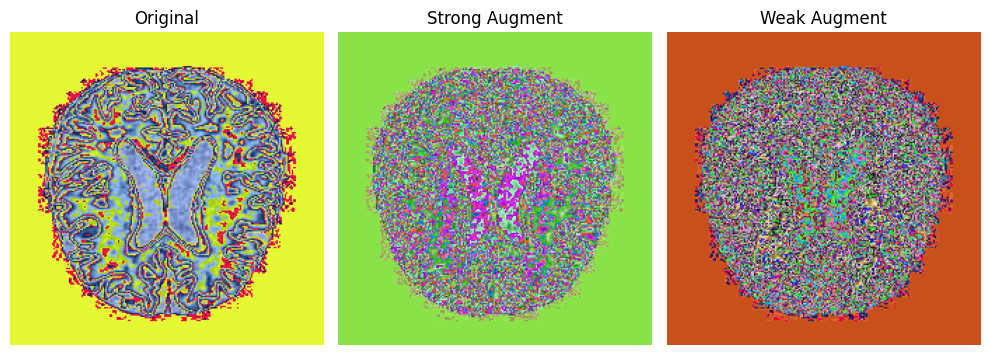

KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

DATA_DIR = '/content/drive/MyDrive/ad'  # Dataset path
CACHE_PATH = '/content/drive/MyDrive/balanced_dataset.pt'
CHECKPOINT_PATH = "/content/drive/MyDrive/fixmatch_ad_checkpoint.pth"
TARGET_COUNT = 1200
NUM_CLASSES = 4

# Transforms
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
rand_augment = transforms.Compose([
    RandAugment(num_ops=2, magnitude=9),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Balanced Dataset
class AugmentedBalancedDataset(Dataset):
    def __init__(self, dataset, target_count, base_transform, augment_transform):
        self.dataset = dataset
        self.target_count = target_count
        self.base_transform = base_transform
        self.augment_transform = augment_transform
        self.final_images = []
        self.final_labels = []

        class_indices = {i: [] for i in range(len(dataset.classes))}
        for idx, (_, label) in enumerate(dataset):
            class_indices[label].append(idx)

        for label, indices in class_indices.items():
            count = len(indices)
            for idx in indices:
                img, _ = dataset[idx]
                self.final_images.append(base_transform(img))
                self.final_labels.append(label)

            if count < target_count:
                extra_needed = target_count - count
                extra_indices = np.random.choice(indices, extra_needed, replace=True)
                for idx in extra_indices:
                    img, _ = dataset[idx]
                    self.final_images.append(augment_transform(img))
                    self.final_labels.append(label)

    def __len__(self):
        return len(self.final_images)

    def __getitem__(self, idx):
        return self.final_images[idx], self.final_labels[idx]

# Load or preprocess dataset
if os.path.exists(CACHE_PATH):
    print("Loading preprocessed dataset from cache...")
    data = torch.load(CACHE_PATH, weights_only=False)

    balanced_dataset = data['dataset']
else:
    print("Creating balanced dataset...")
    raw_dataset = datasets.ImageFolder(DATA_DIR)
    balanced_dataset = AugmentedBalancedDataset(raw_dataset, TARGET_COUNT, base_transform, rand_augment)
    torch.save({'dataset': balanced_dataset}, CACHE_PATH)
    print(f"Balanced dataset saved to: {CACHE_PATH}")

# Split into labeled, unlabeled, test sets
labeled_idx, unlabeled_idx = train_test_split(
    np.arange(len(balanced_dataset)),
    train_size=1000,
    stratify=[label for _, label in balanced_dataset],
    random_state=42
)
labeled_set = Subset(balanced_dataset, labeled_idx)
unlabeled_set = Subset(balanced_dataset, unlabeled_idx)
test_set = datasets.ImageFolder(DATA_DIR, transform=base_transform)

labeled_loader = DataLoader(labeled_set, batch_size=64, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Model definition
class WideResNetFixMatch(nn.Module):
    def __init__(self, num_classes):
        super(WideResNetFixMatch, self).__init__()
        self.model = models.wide_resnet50_2(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# FixMatch training with checkpointing
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10, threshold=0.95):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    to_pil = transforms.ToPILImage()
    losses = []

    start_epoch = 0
    if os.path.exists(CHECKPOINT_PATH):
        print("Loading checkpoint...")
        checkpoint = torch.load(CHECKPOINT_PATH)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_epoch = checkpoint['epoch'] + 1
        losses = checkpoint['losses']
        print(f"Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        model.train()
        for (x_lb, y_lb), (x_ulb, _) in zip(labeled_loader, unlabeled_loader):
            x_lb, y_lb = x_lb.to(device), y_lb.to(device)
            x_ulb = x_ulb.to(device)

            logits_x = model(x_lb)
            loss_x = criterion(logits_x, y_lb)

            x_ulb_w = torch.stack([base_transform(to_pil(img.cpu())) for img in x_ulb])
            x_ulb_s = torch.stack([rand_augment(to_pil(img.cpu())) for img in x_ulb])
            x_ulb_w, x_ulb_s = x_ulb_w.to(device), x_ulb_s.to(device)

            with torch.no_grad():
                outputs_u_w = model(x_ulb_w)
                probs = torch.softmax(outputs_u_w, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_s = model(x_ulb_s)
            loss_u = (criterion(outputs_u_s, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'losses': losses
        }, CHECKPOINT_PATH)

    return losses

# Evaluation
def evaluate(model, test_loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

    acc = 100 * np.mean(np.array(preds) == np.array(labels))
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    print(f"Accuracy: {acc:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

# Visualize Augmentations
def visualize_augmentations(dataset, idx=0):
    to_pil = transforms.ToPILImage()
    img, label = dataset[idx]
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))

    axs[0].imshow(to_pil(img))
    axs[0].set_title("Original")
    axs[1].imshow(to_pil(rand_augment(to_pil(img))))
    axs[1].set_title("Strong Augment")
    axs[2].imshow(to_pil(base_transform(to_pil(img))))
    axs[2].set_title("Weak Augment")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Run All ===
model = WideResNetFixMatch(num_classes=NUM_CLASSES)
visualize_augmentations(test_set, idx=10)
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=10)
evaluate(model, test_loader)

# Plot Loss
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


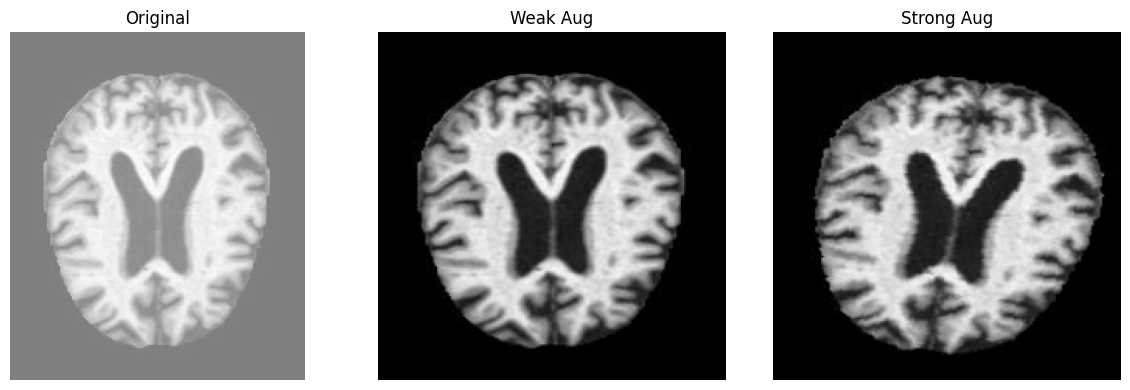

In [ ]:
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Path to your dataset
DATA_DIR = '/content/drive/MyDrive/ad'

# Normalization for medical images
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

# Augmentation definitions
weak_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    normalize
])

# Load dataset without transform
dataset = datasets.ImageFolder(DATA_DIR)

# Select a sample image
sample_img, _ = dataset[0]

# Apply augmentations
original_tensor = transforms.ToTensor()(sample_img)
weak_tensor = weak_transform(sample_img)
strong_tensor = strong_transform(sample_img)

# Unnormalize for display
def unnormalize(tensor):
    return torch.clamp(tensor * 0.5 + 0.5, 0, 1)

# Display side-by-side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Original", "Weak Aug", "Strong Aug"]
images = [original_tensor, weak_tensor, strong_tensor]

for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(transforms.ToPILImage()(unnormalize(img)))
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


Creating balanced dataset...


Balanced dataset saved to: /content/drive/MyDrive/balanced_ad_dataset.pt


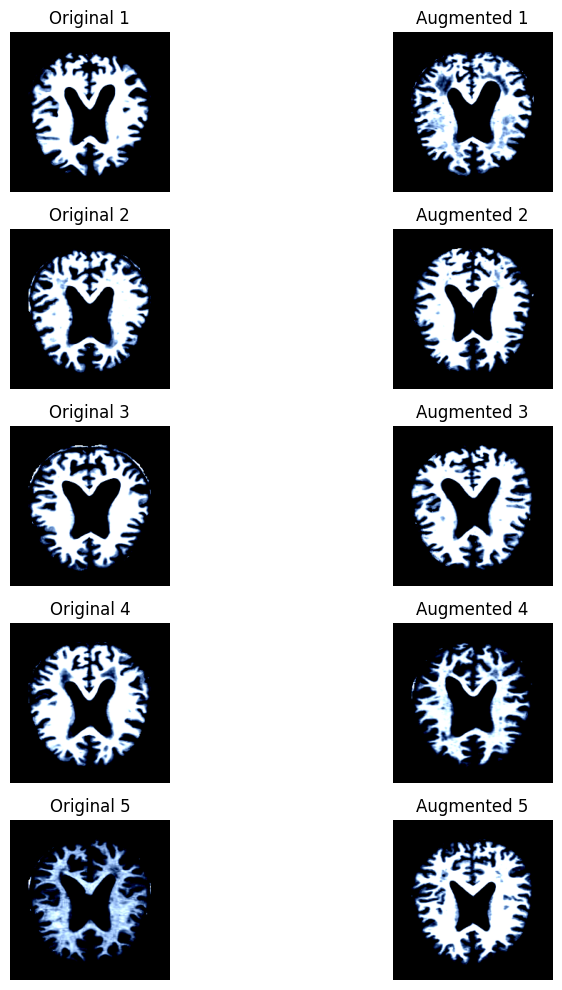

Total samples in balanced dataset: 7840


In [ ]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop
from PIL import Image
import matplotlib.pyplot as plt

# Paths and settings
DATA_DIR = '/content/drive/MyDrive/ad'  # Change if necessary
CACHE_PATH = '/content/drive/MyDrive/balanced_ad_dataset.pt'  # Path to save/load processed dataset
TARGET_COUNT = 1200  # Target samples per class
NUM_CLASSES = 4  # Number of classes

# Define clean augmentations
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

clean_augmentation = transforms.Compose([
    RandomHorizontalFlip(),
    RandomRotation(20),
    RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Augmented Dataset
class AugmentedBalancedDataset(Dataset):
    def __init__(self, dataset, target_count, base_transform, augment_transform):
        self.dataset = dataset
        self.target_count = target_count
        self.base_transform = base_transform
        self.augment_transform = augment_transform
        self.final_images = []
        self.final_labels = []

        class_indices = {i: [] for i in range(len(dataset.classes))}
        for idx, (_, label) in enumerate(dataset):
            class_indices[label].append(idx)

        for label, indices in class_indices.items():
            count = len(indices)
            # Add original images
            for idx in indices:
                img, _ = dataset[idx]
                self.final_images.append(base_transform(img))
                self.final_labels.append(label)

            # Augment to reach target count
            if count < target_count:
                extra_needed = target_count - count
                extra_indices = np.random.choice(indices, extra_needed, replace=True)
                for idx in extra_indices:
                    img, _ = dataset[idx]
                    self.final_images.append(augment_transform(img))
                    self.final_labels.append(label)

    def __len__(self):
        return len(self.final_images)

    def __getitem__(self, idx):
        return self.final_images[idx], self.final_labels[idx]

# Load or preprocess dataset
if os.path.exists(CACHE_PATH):
    print("Loading preprocessed dataset from cache...")
    data = torch.load(CACHE_PATH)
    balanced_dataset = data['dataset']
else:
    print("Creating balanced dataset...")
    raw_dataset = datasets.ImageFolder(DATA_DIR)
    balanced_dataset = AugmentedBalancedDataset(raw_dataset, TARGET_COUNT, base_transform, clean_augmentation)
    torch.save({'dataset': balanced_dataset}, CACHE_PATH)
    print(f"Balanced dataset saved to: {CACHE_PATH}")

# Visualize original and augmented images
def visualize_samples(dataset, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 2*n_samples))
    for i in range(n_samples):
        # Original image
        original_img, _ = dataset[i]
        axes[i, 0].imshow(np.transpose(original_img.numpy(), (1, 2, 0)))
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        # Augmented image (after applying clean augmentation)
        augmented_img, _ = dataset[i + n_samples]
        axes[i, 1].imshow(np.transpose(augmented_img.numpy(), (1, 2, 0)))
        axes[i, 1].set_title(f"Augmented {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize balanced dataset samples
visualize_samples(balanced_dataset)

# Check length of final dataset
print(f"Total samples in balanced dataset: {len(balanced_dataset)}")


✅ Saved balanced dataset with 4800 samples to: /content/drive/MyDrive/balanced_ad_1200.pt


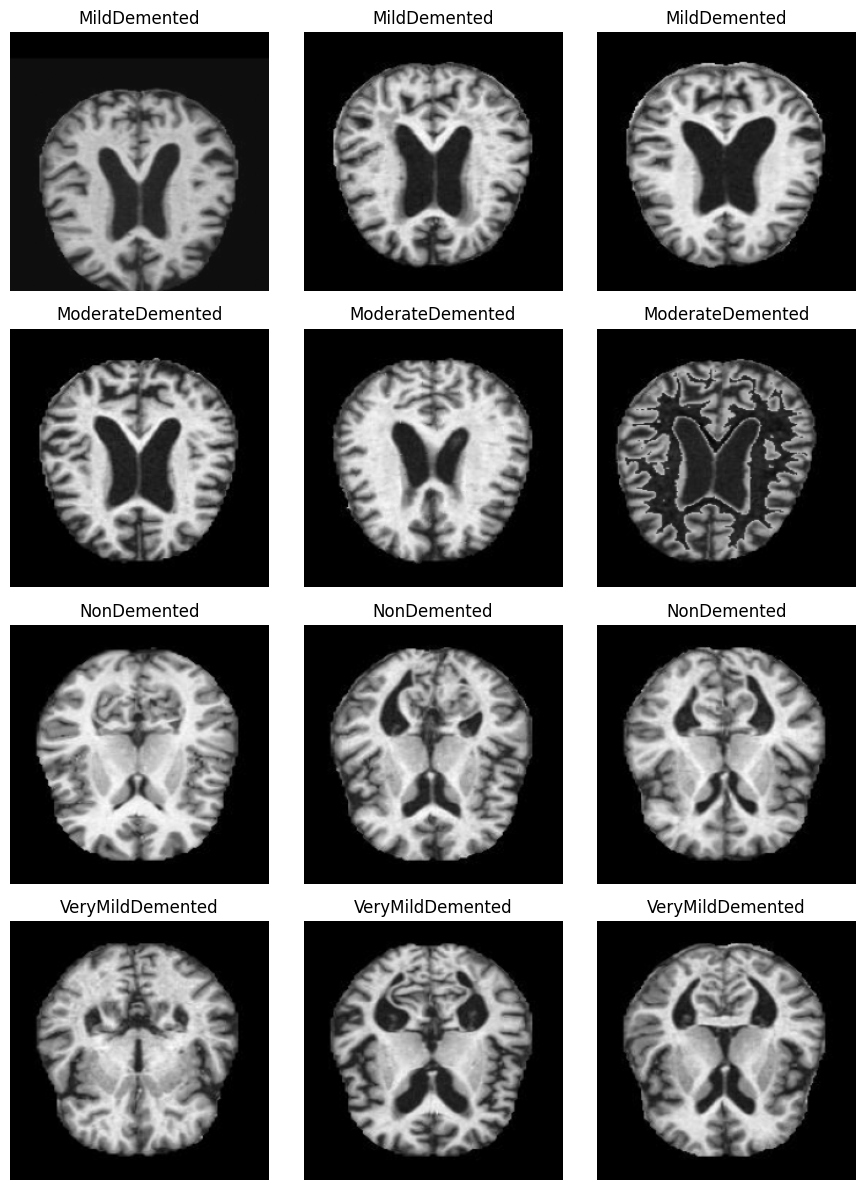

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

# Paths
DATA_DIR = '/content/drive/MyDrive/ad'
CACHE_PATH = '/content/drive/MyDrive/balanced_ad_1200.pt'
TARGET_COUNT = 1200
NUM_CLASSES = 4
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Transforms
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

augment_transform = transforms.Compose([
    RandAugment(num_ops=2, magnitude=7),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class BalancedDataset(Dataset):
    def __init__(self, dataset, target_count=1200, transform=None, augment=None):
        self.data = []
        self.labels = []
        self.classes = dataset.classes
        self.transform = transform
        self.augment = augment

        # Group by class
        class_to_images = {i: [] for i in range(len(self.classes))}
        for img_path, label in dataset.samples:
            class_to_images[label].append(img_path)

        for label, img_paths in class_to_images.items():
            imgs = img_paths.copy()
            count = len(imgs)

            if count > target_count:
                imgs = random.sample(imgs, target_count)
            elif count < target_count:
                extra_needed = target_count - count
                extra_imgs = random.choices(imgs, k=extra_needed)
                imgs += extra_imgs

            for img_path in imgs:
                img = Image.open(img_path).convert('RGB')
                if count < target_count and img_path in extra_imgs:
                    img = self.augment(img)
                else:
                    img = self.transform(img)
                self.data.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Load original dataset
raw_dataset = datasets.ImageFolder(DATA_DIR)

# Create balanced dataset
balanced_dataset = BalancedDataset(
    dataset=raw_dataset,
    target_count=TARGET_COUNT,
    transform=base_transform,
    augment=augment_transform
)

# Save the dataset
torch.save({
    'data': balanced_dataset.data,
    'labels': balanced_dataset.labels,
    'classes': raw_dataset.classes
}, CACHE_PATH)

print(f"✅ Saved balanced dataset with {len(balanced_dataset)} samples to: {CACHE_PATH}")
# Load class names
class_names = raw_dataset.classes

# Plot examples from the balanced dataset
def show_examples(dataset, num_per_class=3):
    fig, axs = plt.subplots(NUM_CLASSES, num_per_class, figsize=(num_per_class*3, NUM_CLASSES*3))
    shown = {i: 0 for i in range(NUM_CLASSES)}

    for img, label in dataset:
        if shown[label] < num_per_class:
            ax = axs[label][shown[label]]
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(f"{class_names[label]}")
            ax.axis('off')
            shown[label] += 1

        if all(shown[i] >= num_per_class for i in range(NUM_CLASSES)):
            break

    plt.tight_layout()
    plt.show()

show_examples(balanced_dataset)


In [ ]:
# ----------------------------
# 1. Imports & Setup
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Setup
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Transforms
# ----------------------------
transform_weak = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

transform_strong = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ----------------------------
# 3. Custom Dataset Class for FixMatch
# ----------------------------
class FixMatchDataset(Dataset):
    def __init__(self, base_dataset, transform_weak, transform_strong):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        return self.transform_weak(img), self.transform_strong(img)

    def __len__(self):
        return len(self.base_dataset)

# ----------------------------
# 4. Load Custom Balanced Dataset
# ----------------------------
# Set your path and number of classes
data_path = "/content/drive/MyDrive/Balanced_AD"  # <-- Update this
num_classes = 4                                   # <-- Update if different

# Load dataset
full_dataset = ImageFolder(root=data_path, transform=transform_weak)

# Split into labeled and unlabeled
labels = [sample[1] for sample in full_dataset]
labeled_size = 800  # change depending on your need
labeled_indices, unlabeled_indices = train_test_split(
    np.arange(len(full_dataset)), train_size=labeled_size,
    stratify=labels, random_state=42
)

labeled_data = Subset(full_dataset, labeled_indices)
unlabeled_data = Subset(ImageFolder(root=data_path, transform=None), unlabeled_indices)  # raw for 2 views

test_data = ImageFolder(root=data_path, transform=transform_test)

batch_size = 64
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(FixMatchDataset(unlabeled_data, transform_weak, transform_strong),
                              batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

checkpoint_dir = "/content/drive/MyDrive/fixmatch_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ----------------------------
# 5. EfficientNet Model
# ----------------------------
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetCustom, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# ----------------------------
# 6. FixMatch Training Function
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=0, epochs=10, threshold=0.95):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        model.train()

        for (inputs_x, targets_x), (inputs_u_weak, inputs_u_strong) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u_weak, inputs_u_strong = inputs_u_weak.to(device), inputs_u_strong.to(device)

            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(checkpoint_dir, "checkpoint.pth"))

        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth"))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return epoch_losses

# ----------------------------
# 7. Evaluation Function
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1

# ----------------------------
# 8. Run Everything
# ----------------------------
model = EfficientNetCustom(num_classes)

start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming from epoch {start_epoch}")

losses = train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=start_epoch, epochs=10)
evaluate(model, test_loader)

plt.plot(range(start_epoch + 1, start_epoch + 1 + len(losses)), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FixMatch Loss Over Epochs")
plt.grid()
plt.show()


In [ ]:
# ----------------------------
# 1. Imports & Setup
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import wide_resnet50_2
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random

torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Data Transforms
# ----------------------------
transform_weak = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

transform_strong = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ----------------------------
# 3. FixMatch Dataset
# ----------------------------
class FixMatchDataset(Dataset):
    def __init__(self, base_dataset, transform_weak, transform_strong):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        return self.transform_weak(img), self.transform_strong(img)

    def __len__(self):
        return len(self.base_dataset)

# ----------------------------
# 4. CIFAR-10 Dataset
# ----------------------------
train_dataset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_weak)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

labels = np.array(train_dataset.targets)
labeled_size = 4000
labeled_indices, unlabeled_indices = train_test_split(
    np.arange(len(train_dataset)), train_size=labeled_size,
    stratify=labels, random_state=42
)

labeled_data = Subset(train_dataset, labeled_indices)
unlabeled_data = Subset(train_dataset_raw, unlabeled_indices)

batch_size = 4
labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(FixMatchDataset(unlabeled_data, transform_weak, transform_strong),
                              batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

checkpoint_dir = "./wrn_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ----------------------------
# 5. WideResNet-50 Model
# ----------------------------
class WideResNet50ForCIFAR10(nn.Module):
    def __init__(self):
        super(WideResNet50ForCIFAR10, self).__init__()
        self.model = wide_resnet50_2(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

# ----------------------------
# 6. FixMatch Training
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=0, epochs=10, threshold=0.95):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0

        for (inputs_x, targets_x), (inputs_u_weak, inputs_u_strong) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u_weak, inputs_u_strong = inputs_u_weak.to(device), inputs_u_strong.to(device)

            # Supervised loss
            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            # Unsupervised loss
            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)

        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth"))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return epoch_losses

# ----------------------------
# 7. Evaluation
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nTest Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1

# ----------------------------
# 8. Run Training and Evaluation
# ----------------------------
model = WideResNet50ForCIFAR10()
start_epoch = 0
if os.path.exists(os.path.join(checkpoint_dir, "checkpoint.pth")):
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pth"))
    model.load_state_dict(checkpoint["model_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming from epoch {start_epoch}")

losses = train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=start_epoch, epochs=10)
evaluate(model, test_loader)

plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


100%|██████████| 170M/170M [00:01<00:00, 105MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 198MB/s]


In [1]:
!git config --global user.email "sadiatahsin3.1415@gmail.com"
!git config --global user.name "sadia-tahsin"
!git clone https://github.com/sadia-tahsin/IDT-project2-SSL.git


Cloning into 'IDT-project2-SSL'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [3]:
!cp fixmatch-cifar10.ipynb /content/IDT-project2-SSL/
%cd /content/IDT-project2-SSL/

cp: cannot stat 'fixmatch-cifar10.ipynb': No such file or directory
/content/IDT-project2-SSL
